In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product, count
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

import xarray as xr
import pandas as pd
import cytoolz as tz
from cytoolz import compose, merge_with, groupby
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"))

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
                gm2: {$gte: 0.005, $lt: 0.011}
            },
        },
        {
            $project: {
                tag: true,
                gm2: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 14]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("gm2", DoubleType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()

Loading data...
root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)



In [4]:
combiner = load_combiner(3, [["C1p", "I1p", "I1p"]], allow_various=False)
combined = df.select("tag", "gm2", combiner("hits").alias("combined")).cache()
combined.printSchema()

root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- combined: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- comb: array (nullable = false)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- t: double (nullable = false)
 |    |    |    |    |-- x: double (nullable = false)
 |    |    |    |    |-- y: double (nullable = false)
 |    |    |    |    |-- as_: map (nullable = false)
 |    |    |    |    |    |-- key: string
 |    |    |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |    |    |-- ke: double (nullable = false)
 |    |    |    |    |-- flag: integer (nullable = true)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    

In [5]:
def gen():
    pubhit = count()
    for row in combined.toLocalIterator():
        d = row.asDict(True)
        yield {"dim": "tag", "tag": d["tag"], "gm2": d["gm2"]}
        for c in d["combined"]:
            i = next(pubhit)
            yield {"dim": "hit", "tag": d["tag"], "hit": i, "flag": c["flag"]}
            for j, (h, k) in enumerate(zip(c["comb"], ["C1p", "I1p", "I1p"])):
                yield {"dim": "hit,as_", "tag": d["tag"], "hit": i, "as_": f"h{j}{k}",
                       "t": h["t"], "x": h["x"], "y": h["y"],
                       "pz": h["as_"][k]["pz"], "px": h["as_"][k]["px"], "py": h["as_"][k]["py"],
                       "ke": h["as_"][k]["ke"]}


d = tz.groupby("dim", gen())
ds = xr.merge([
    pd.DataFrame(d["tag"]).set_index("tag").drop(columns="dim").to_xarray(),
    pd.DataFrame(d["hit"]).set_index("hit").drop(columns="dim").to_xarray().rename({"tag": "tag_"}),
    pd.DataFrame(d["hit,as_"]).set_index(["hit", "as_"]).drop(columns=["dim", "tag"]).to_xarray(),
])
da = ds[["t", "x", "y", "pz", "px", "py", "ke"]].to_array("quantity")
del d
ds

<xarray.Dataset>
Dimensions:  (as_: 3, hit: 10200, tag: 231644)
Coordinates:
  * tag      (tag) int64 158649042 158648463 158649478 ... 156993587 157183736
  * hit      (hit) int64 0 1 2 3 4 5 6 ... 10194 10195 10196 10197 10198 10199
  * as_      (as_) object 'h0C1p' 'h1I1p' 'h2I1p'
Data variables:
    gm2      (tag) float64 0.005048 0.005569 0.005825 ... 0.011 0.011 0.011
    flag     (hit) int64 8 0 6 6 10 10 0 0 0 6 8 ... 0 0 12 14 14 4 0 12 0 12 0
    tag_     (hit) int64 158649022 158649182 158649017 ... 157090022 157227504
    ke       (hit, as_) float64 13.37 4.808 16.6 17.37 ... 15.41 6.026 3.982
    px       (hit, as_) float64 -114.2 130.6 -134.0 ... 25.95 -99.39 -71.47
    py       (hit, as_) float64 41.37 236.1 -269.2 -82.4 ... 61.01 193.9 -243.6
    pz       (hit, as_) float64 82.14 -94.45 438.0 142.6 ... 142.8 -234.5 56.89
    t        (hit, as_) float64 2.082e+03 5.263e+03 ... 5.224e+03 5.303e+03
    x        (hit, as_) float64 -20.05 7.249 -7.067 ... 4.422 -5.16 -3.662


In [6]:
inlabframe = da.to_dataset(dim="as_")
inlabframe["summed"] = da.loc[{"quantity": ["pz", "px", "py", "ke"]}].sum("as_")
inlabframe

<xarray.Dataset>
Dimensions:   (hit: 10200, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
  * hit       (hit) int64 0 1 2 3 4 5 6 ... 10194 10195 10196 10197 10198 10199
Data variables:
    h0C1p     (quantity, hit) float64 2.082e+03 2.097e+03 ... 69.92 15.41
    h1I1p     (quantity, hit) float64 5.263e+03 5.153e+03 ... 3.561 6.026
    h2I1p     (quantity, hit) float64 5.402e+03 5.297e+03 ... 4.35 3.982
    summed    (quantity, hit) float64 nan nan nan nan ... 14.04 77.83 25.42

In [7]:
cond = {}

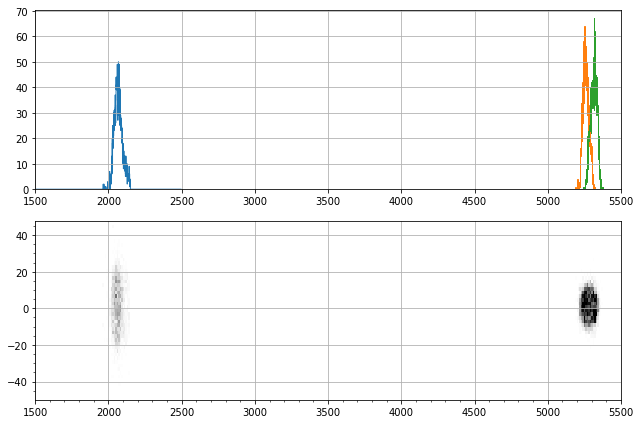

In [23]:
df = inlabframe.loc[{"quantity": "t"}].to_dataframe()
t0 = df["h0C1p"]
t1 = df["h1I1p"]
t2 = df["h2I1p"]

df = inlabframe.loc[{"quantity": "x"}].to_dataframe()
x0 = df["h0C1p"]
x1 = df["h1I1p"]
x2 = df["h2I1p"]

df = inlabframe.loc[{"quantity": "y"}].to_dataframe()
y0 = df["h0C1p"]
y1 = df["h1I1p"]
y2 = df["h2I1p"]

# where = slice(None)
where = cond["labframe"] & ~cond["bad_hit12"]

plt.figure(figsize=(9, 6))
plt.subplot(211)
plt.hist(t0[where], bins=np.arange(1500, 2500, 1), histtype="step")
plt.hist(t1[where], bins=np.arange(5000, 5500, 1), histtype="step")
plt.hist(t2[where], bins=np.arange(5000, 5500, 1), histtype="step")
plt.grid(True)
plt.xlim(1500, 5500)

plt.subplot(212)
hist, *_ = np.histogram2d(
    t0[where], y0[where],
    bins=(np.arange(1500, 5500, 10),
          np.arange(-50, 50, 2)))
tmp, *_ = np.histogram2d(
    t1[where], y1[where],
    bins=(np.arange(1500, 5500, 10),
          np.arange(-50, 50, 2)))
hist += tmp
tmp, *_ = np.histogram2d(
    t2[where], y2[where],
    bins=(np.arange(1500, 5500, 10),
          np.arange(-50, 50, 2)))
hist += tmp
plt.pcolormesh(
    np.arange(1500, 5500, 10),
    np.arange(-50, 50, 2),
    hist.T,
    cmap="Greys")
plt.minorticks_on()
plt.grid(True)
plt.xlim(1500, 5500)
plt.clim(0, 50)
plt.tight_layout()
plt.show()

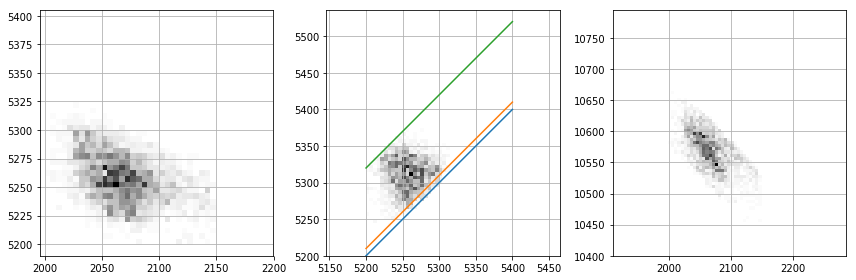

In [21]:
cond["bad_hit12"] = 120 < (t2 - t1)

# where = slice(None)
# where = ~cond["bad_hit12"]
where = cond["labframe"] & ~cond["bad_hit12"]
norm = None
# norm = LogNorm()

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist2d(
    t0[where], t1[where],
    bins=(np.arange(2000, 2200, 5),
          np.arange(5200, 5400, 5)),
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    t1[where], t2[where],
    bins=(np.arange(5200, 5400, 5),
          np.arange(5200, 5500, 5)),
    cmap="Greys",
    norm=norm)
x = np.linspace(5200, 5400)
plt.plot(x, x)
plt.plot(x, x + 10)
plt.plot(x, x + 120)
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist2d(
    t0[where], (t1 + t2)[where],
    bins=(np.arange(2000, 2200, 5),
          np.arange(10400, 10800, 5)),
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

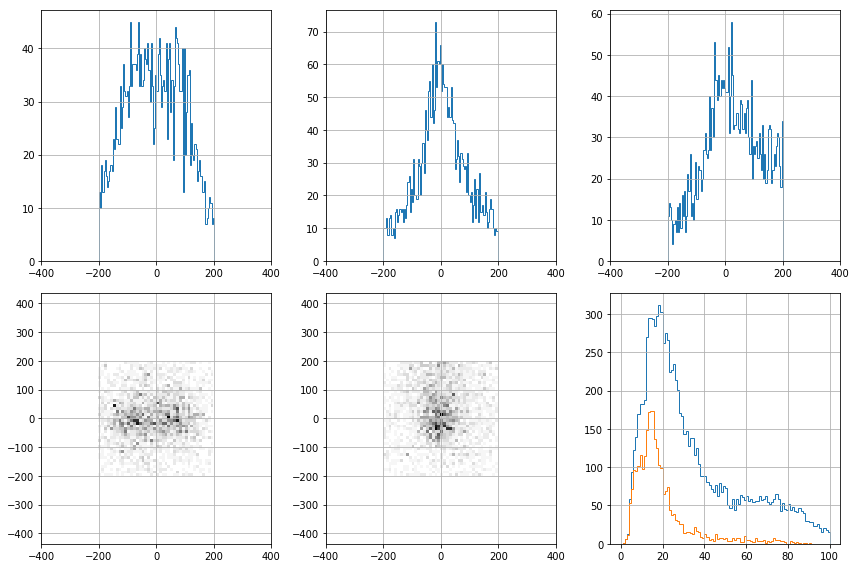

In [20]:
df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe()
)
cond["labframe"] = (
    (-200 < df["px"]) & (df["px"] < 200)
    & (-200 < df["py"]) & (df["py"] < 200)
    & (-200 < df["pz"]) & (df["pz"] < 200)
)
# where = slice(None)
# where = ~cond["bad_hit12"]
# where = cond["labframe"]
where = cond["labframe"] & ~cond["bad_hit12"]
norm = None
# norm = LogNorm()

plt.figure(figsize=[12, 8])
plt.subplot(231)
plt.hist(
    df["px"][where],
    bins=np.linspace(-400, 400, 201),
    histtype="step")
plt.xlim(-400, 400)
plt.grid(True)
# plt.yscale("log")

plt.subplot(232)
plt.hist(
    df["py"][where],
    bins=np.linspace(-400, 400, 201),
    histtype="step")
plt.xlim(-400, 400)
plt.grid(True)
# plt.yscale("log")

plt.subplot(233)
plt.hist(
    df["pz"][where],
    bins=np.linspace(-400, 400, 201),
    histtype="step")
plt.xlim(-400, 400)
plt.grid(True)
# plt.yscale("log")

plt.subplot(234)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(235)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(236)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
# plt.yscale("log")
plt.tight_layout()
plt.show()

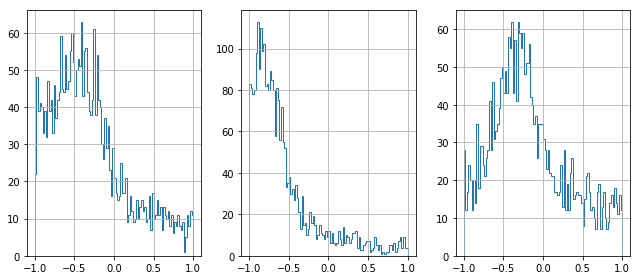

In [25]:
def angle_btw(a, b):
    q = {"quantity": ["pz", "px", "py"]}
    return (
        (a.loc[q] * b.loc[q]).sum("quantity")
        / (a.loc[q] ** 2).sum("quantity") ** 0.5
        / (b.loc[q] ** 2).sum("quantity") ** 0.5
    )


where = cond["labframe"] & ~cond["bad_hit12"]

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.hist(
    angle_btw(inlabframe["h0C1p"], inlabframe["h1I1p"]).to_pandas()[where],
    bins=np.linspace(-1, 1, 101),
    histtype="step",
)
plt.grid(True)

plt.subplot(132)
plt.hist(
    angle_btw(inlabframe["h1I1p"], inlabframe["h2I1p"]).to_pandas()[where],
    bins=np.linspace(-1, 1, 101),
    histtype="step",
)
plt.grid(True)

plt.subplot(133)
plt.hist(
    angle_btw(inlabframe["h2I1p"], inlabframe["h0C1p"]).to_pandas()[where],
    bins=np.linspace(-1, 1, 101),
    histtype="step",
)
plt.grid(True)
plt.tight_layout()
plt.show()

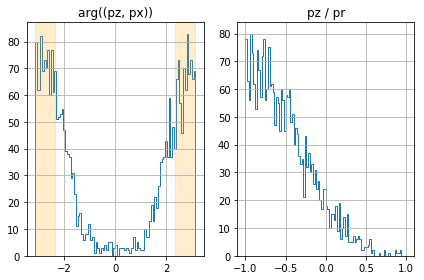

In [27]:
z = inlabframe["h1I1p"].loc[{"quantity": "pz"}]
x = inlabframe["h1I1p"].loc[{"quantity": "px"}]
y = inlabframe["h1I1p"].loc[{"quantity": "py"}]
r = (z ** 2 + x ** 2 + y ** 2) ** 0.5
phiy = xr.apply_ufunc(np.arctan2, x, z).to_pandas()
cond["phi"] = (phiy < -3/4 * np.pi) | (3/4 * np.pi < phiy)

# where = slice(None)
where = cond["labframe"] & ~cond["bad_hit12"]

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("arg((pz, px))")
hist11, *_ = plt.hist(
    phiy[where],
    bins=np.linspace(-np.pi, np.pi, 91),
    histtype="step")
plt.grid(True)
plt.axvspan(-np.pi, -3/4 * np.pi, color="orange", alpha=0.2)
plt.axvspan(3/4 * np.pi, np.pi, color="orange", alpha=0.2)

plt.subplot(122)
plt.title("pz / pr")
hist21, *_ = plt.hist(
    (z / r).to_pandas()[where],
    bins=np.linspace(-1, 1, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

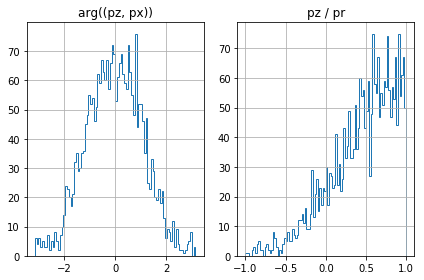

In [28]:
z = inlabframe["h2I1p"].loc[{"quantity": "pz"}]
x = inlabframe["h2I1p"].loc[{"quantity": "px"}]
y = inlabframe["h2I1p"].loc[{"quantity": "py"}]
r = (z ** 2 + x ** 2 + y ** 2) ** 0.5
phiy = xr.apply_ufunc(np.arctan2, x, z).to_pandas()

# where = slice(None)
where = cond["labframe"] & ~cond["bad_hit12"]

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("arg((pz, px))")
hist12, *_ = plt.hist(
    phiy[where],
    bins=np.linspace(-np.pi, np.pi, 91),
    histtype="step")
plt.grid(True)

plt.subplot(122)
plt.title("pz / pr")
hist22, *_ = plt.hist(
    (z / r).to_pandas()[where],
    bins=np.linspace(-1, 1, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

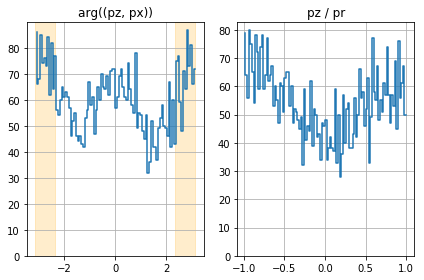

In [31]:
# where = slice(None)
where = cond["labframe"] & ~cond["bad_hit12"]

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("arg((pz, px))")
plt.step(np.linspace(-np.pi, np.pi, 91)[1:], hist11 + hist12)
plt.axvspan(-np.pi, -3/4 * np.pi, color="orange", alpha=0.2)
plt.axvspan(3/4 * np.pi, np.pi, color="orange", alpha=0.2)
plt.ylim(0, None)
plt.grid(True)

plt.subplot(122)
plt.title("pz / pr")
plt.step(np.linspace(-1, 1, 101)[1:], hist21 + hist22)
plt.ylim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
(n,), (m,) = inlabframe["hit"].shape, inlabframe["quantity"].shape
frame = xr.DataArray(
    n * [np.eye(m)],
    dims=["hit", "quantity", "new"],
    coords={"hit": inlabframe["hit"],
            "quantity": inlabframe["quantity"],
            "new": inlabframe["quantity"].values},
    name="frame")

x = inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h0C1p"]
y = inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h1I1p"]
z = xr.apply_ufunc(np.cross, x, y,
                   input_core_dims=[["quantity"], ["quantity"]],
                   output_core_dims=[["quantity"]])
xunit = (x / (x ** 2).sum("quantity") ** 0.5).rename("xunit")
zunit = (z / (z ** 2).sum("quantity") ** 0.5).rename("zunit")
yunit = xr.apply_ufunc(np.cross, zunit, xunit).rename("yunit")

frame.loc[{"quantity": ["pz", "px", "py"], "new": "px"}] = xunit.transpose("hit", "quantity")
frame.loc[{"quantity": ["pz", "px", "py"], "new": "py"}] = yunit.transpose("hit", "quantity")
frame.loc[{"quantity": ["pz", "px", "py"], "new": "pz"}] = zunit.transpose("hit", "quantity")

inmolframe = xr.Dataset({
    k: (inlabframe[k] * frame).sum("quantity")
    for k in ["h0C1p", "h1I1p", "h2I1p"]
}).rename({"new": "quantity"})
inmolframe["summed"] = (
    inmolframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]
    .to_array("as_")
    .sum("as_"))
inmolframe

<xarray.Dataset>
Dimensions:   (hit: 10200, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
  * hit       (hit) int64 0 1 2 3 4 5 6 ... 10194 10195 10196 10197 10198 10199
Data variables:
    h0C1p     (hit, quantity) float64 2.082e+03 -20.05 ... -7.105e-15 15.41
    h1I1p     (hit, quantity) float64 5.263e+03 7.249 14.23 ... 280.6 6.026
    h2I1p     (hit, quantity) float64 5.402e+03 -7.067 -13.08 ... -220.5 3.982
    summed    (hit, quantity) float64 nan nan nan -276.7 ... -51.12 60.16 25.42

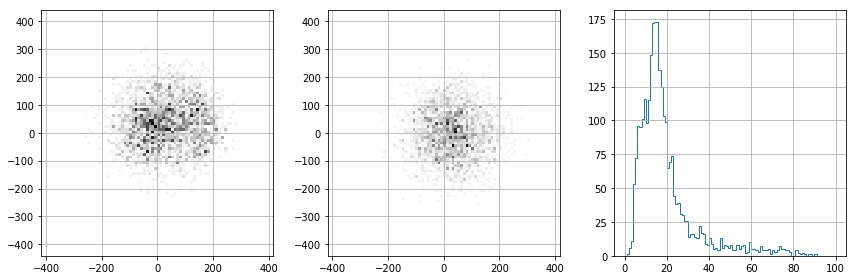

In [37]:
df = (
    inmolframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())

# where = cond["labframe"]
where = cond["labframe"] & ~cond["bad_hit12"]

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

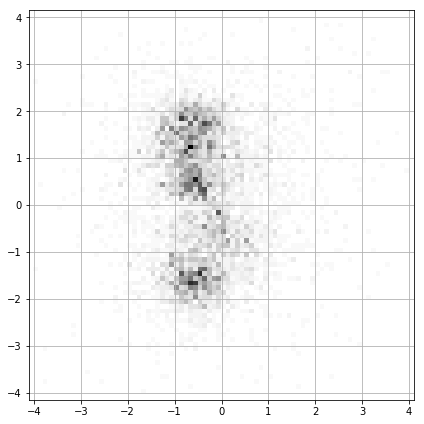

In [40]:
edges = np.linspace(-4, 4, 81)
q = {"quantity": ["pz", "px", "py"]}
r = (inmolframe["h0C1p"].loc[q] ** 2).sum("quantity") ** 0.5

# where = cond["labframe"]
where = cond["labframe"] & ~cond["bad_hit12"]

df = (
    (inmolframe.loc[q] / r)["h1I1p"]
    .to_dataset(dim="quantity")
    .to_dataframe()
)
hist, *_ = np.histogram2d(
    df["px"][where], df["py"][where],
    bins=2*[edges],
)
df = (
    (inmolframe.loc[q] / r)["h2I1p"]
    .to_dataset(dim="quantity")
    .to_dataframe()
)
tmp, *_ = np.histogram2d(
    df["px"][where], df["py"][where],
    bins=2*[edges],
)
hist += tmp

plt.figure(figsize=(6, 6))
plt.pcolormesh(edges, edges, hist.T, cmap="Greys")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()